# Fake News Detection Using LSTM

In [1]:
## Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.stem import PorterStemmer
import re
import tensorflow
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from sklearn.metrics import classification_report,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

In [2]:
## This is the test Data
test_data = pd.read_csv('../input/fake-news/test.csv')

In [3]:
## Import dataset

df = pd.read_csv('../input/fake-news/train.csv')

In [4]:
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [5]:
df["merged"] = df["title"]+" "+df["author"]

In [6]:
df.head()

,id,title,author,text,label,merged
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,Why the Truth Might Get You Fired Consortiumne...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,15 Civilians Killed In Single US Airstrike Hav...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,Iranian woman jailed for fictional unpublished...


## Basic Analysis

In [7]:
## Check the Null Values 
df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
merged    2515
dtype: int64

As you can see there are some **Null Values**. Drop all these Null values because we can not add word by us randomly.

In [8]:
# Drop Null values
df = df.dropna()

In [9]:
# Now count the Unique values to check the data is balanced or not
count = np.unique(df['label'], return_counts=True)
count

(array([0, 1]), array([10361,  7924]))

<AxesSubplot:xlabel='label', ylabel='count'>

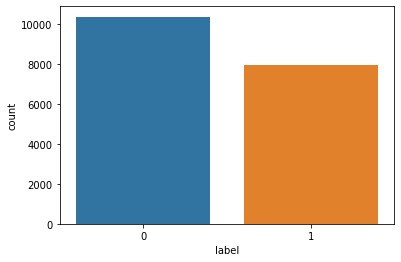

In [10]:
import seaborn as sns
sns.countplot(x='label', data = df)

As you can see the data is balanced, so we don't need to do something here

**First split the dataset into Dependent and Independent Features**

In [11]:
# Dependent Features
Y = df['label']

# Independent Features
X = df.drop('label', axis=1)

## One Hot Representation

In this step we change the dataset into Numerical representation

In [12]:
# make the copy of Dependent Featues and reset the index because we drop the nan values due to this 
# the index is disturb
messages = X.copy()
# messages.reset_index(inplace=True)


In [13]:
messages['title'][1]

'FLYNN: Hillary Clinton, Big Woman on Campus - Breitbart'

In [14]:
messages.reset_index(inplace=True)

**Data Preprocessing**

In [15]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [16]:
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))

In [17]:
ps = PorterStemmer()
corpus = []
for i in range(0, len(messages)):
    review = re.sub('[^a-zA-Z]', ' ', messages['merged'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords]
    review = ' '.join(review)
    corpus.append(review)

In [18]:
corpus[1]

'flynn hillari clinton big woman campu breitbart daniel j flynn'

In [19]:
voc_size = 5000
onehot_repre = [one_hot(words, voc_size) for words in corpus]
onehot_repre[0]

[2472, 3012, 4466, 1787, 3599, 3427, 1046, 1823, 3096, 296, 1296, 452]

As you can see we stemmed the data and change the data into numerical representation

## Word Embedding

In [20]:
sent_length = 20
embedded_docs = pad_sequences(onehot_repre, padding='pre', maxlen=sent_length)
print(embedded_docs[0])

[   0    0    0    0    0    0    0    0 2472 3012 4466 1787 3599 3427
 1046 1823 3096  296 1296  452]


**In above cell we change every sentence into 20 words, if the sentence is less then 20 words then we add zeros at the start.**

## Creating a Model

In [21]:
embedding_vector_features = 40
model = Sequential()
model.add(Embedding(voc_size, embedding_vector_features, input_length=sent_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


2022-07-05 08:57:31.021264: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-05 08:57:31.125801: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-05 08:57:31.126584: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-05 08:57:31.128460: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 40)            200000    
_________________________________________________________________
lstm (LSTM)                  (None, 100)               56400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 256,501
Trainable params: 256,501
Non-trainable params: 0
_________________________________________________________________
None


In [22]:
x_final = np.array(embedded_docs)
y_final = np.array(Y)

In [23]:
x_final.shape, y_final.shape

((18285, 20), (18285,))

### Split the Data into Train and Test

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_final, y_final, test_size=0.1, random_state=42)

### Model Training

In [25]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=64)

2022-07-05 08:57:34.436112: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-07-05 08:57:36.668307: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


258/258 [==============================] - 5s 7ms/step - loss: 0.2043 - accuracy: 0.9150 - val_loss: 0.0362 - val_accuracy: 0.9874
Epoch 2/20
258/258 [==============================] - 1s 5ms/step - loss: 0.0261 - accuracy: 0.9921 - val_loss: 0.0410 - val_accuracy: 0.9858
Epoch 3/20
258/258 [==============================] - 1s 5ms/step - loss: 0.0105 - accuracy: 0.9971 - val_loss: 0.0308 - val_accuracy: 0.9896
Epoch 4/20
258/258 [==============================] - 1s 5ms/step - loss: 0.0062 - accuracy: 0.9987 - val_loss: 0.0205 - val_accuracy: 0.9934
Epoch 5/20
258/258 [==============================] - 1s 5ms/step - loss: 0.0029 - accuracy: 0.9993 - val_loss: 0.0226 - val_accuracy: 0.9896
Epoch 6/20
258/258 [==============================] - 1s 5ms/step - loss: 0.0011 - accuracy: 0.9999 - val_loss: 0.0119 - val_accuracy: 0.9951
Epoch 7/20
258/258 [==============================] - 1s 5ms/step - loss: 0.0015 - accuracy: 0.9996 - val_loss: 0.0193 - val_accuracy: 0.9918
Epoch 8/20
258/25

### Performance Metrics and Accuracy

In [26]:
classes_x = (model.predict(X_test) > 0.5).astype("int32")

**Confusion Matrix**

In [27]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, classes_x)

array([[1028,    8],
       [  11,  782]])

**Accuracy Score**

In [28]:
from sklearn.metrics import accuracy_score
score_0 = accuracy_score(y_test,classes_x)
print(score_0)

0.9896118097320941


In [29]:
model_1 = LogisticRegression(max_iter=900)
model_1.fit(X_train,y_train)
pred_1 = model_1.predict(X_test)
# cr1    = classification_report(y_test,pred_1)
# print(cr1)
score_1 = accuracy_score(y_test,pred_1)
print(score_1)

0.6801530891197376


In [30]:
model_2 = MultinomialNB()
model_2.fit(X_train,y_train)
pred_2 = model_2.predict(X_test)
# cr2    = classification_report(y_test,pred_2)
# print(cr2)
score_2 = accuracy_score(y_test,pred_2)
print(score_2)

0.6418808091853472


In [31]:
model_3 = DecisionTreeClassifier()
model_3.fit(X_train,y_train)
pred_3 = model_3.predict(X_test)
# cr3    = classification_report(y_test,pred_3)
# print(cr3)
score_3 = accuracy_score(y_test,pred_3)
print(score_3)

0.8944778567523237


In [32]:
model_4 = RandomForestClassifier()
model_4.fit(X_train,y_train)
pred_4 = model_4.predict(X_test)
# cr4    = classification_report(y_test,pred_4)
# print(cr4)
score_4 = accuracy_score(y_test,pred_4)
print(score_4)

0.9048660470202297


In [33]:
model_5 = XGBClassifier()
model_5.fit(X_train,y_train)
pred_5 = model_5.predict(X_test)
# cr5    = classification_report(y_test,pred_5)
# print(cr5)
score_5 = accuracy_score(y_test,pred_5)
print(score_5)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:58:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9890650628758885


In [34]:
model_6 = CatBoostClassifier(iterations=200)
model_6.fit(X_train,y_train)
pred_6 = model_6.predict(X_test)
# cr6    = classification_report(y_test,pred_6)
# print(cr6)
score_6 = accuracy_score(y_test,pred_6)

Learning rate set to 0.149025
0:	learn: 0.5838711	total: 66ms	remaining: 13.1s
1:	learn: 0.5281519	total: 75.1ms	remaining: 7.43s
2:	learn: 0.4691876	total: 83.7ms	remaining: 5.5s
3:	learn: 0.4309767	total: 91.8ms	remaining: 4.5s
4:	learn: 0.3997451	total: 100ms	remaining: 3.91s
5:	learn: 0.3907898	total: 109ms	remaining: 3.51s
6:	learn: 0.3758978	total: 118ms	remaining: 3.24s
7:	learn: 0.3621820	total: 126ms	remaining: 3.03s
8:	learn: 0.3556023	total: 135ms	remaining: 2.87s
9:	learn: 0.3452694	total: 143ms	remaining: 2.72s
10:	learn: 0.3380355	total: 152ms	remaining: 2.6s
11:	learn: 0.3314779	total: 160ms	remaining: 2.5s
12:	learn: 0.3233392	total: 168ms	remaining: 2.41s
13:	learn: 0.3159923	total: 176ms	remaining: 2.34s
14:	learn: 0.3096679	total: 184ms	remaining: 2.27s
15:	learn: 0.3018874	total: 195ms	remaining: 2.24s
16:	learn: 0.2987713	total: 204ms	remaining: 2.2s
17:	learn: 0.2930773	total: 214ms	remaining: 2.16s
18:	learn: 0.2891599	total: 222ms	remaining: 2.12s
19:	learn: 0.2

In [35]:
results = pd.DataFrame([["Logistic Regression",score_1],["Naive Bayes",score_2],["Decision Tree",score_3],
                       ["Random Forest",score_4],["XGBOOST",score_5],["CatBoost",score_6],["LSTM",score_0]],columns=["Model","Accuracy"])

results

,Model,Accuracy
0,Logistic Regression,0.680153
1,Naive Bayes,0.641881
2,Decision Tree,0.894478
3,Random Forest,0.904866
4,XGBOOST,0.989065
5,CatBoost,0.979224
6,LSTM,0.989612
